## Prepare

### Read data
Requirement: some csv with several time series with 'time' field 

Current: show the data of 1000p interAS queue

../BBR_test/ns-3.27/MboxStatistics/all-data_176.csv n_flow: 10


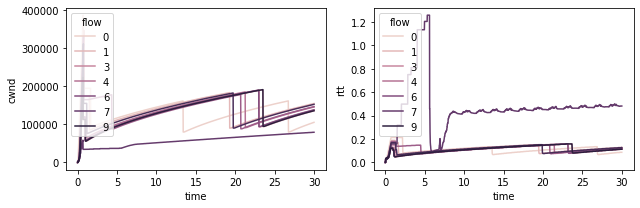

<Figure size 432x288 with 0 Axes>

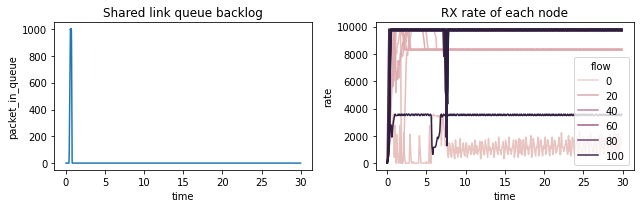

../BBR_test/ns-3.27/MboxStatistics/all-data_177.csv n_flow: 10


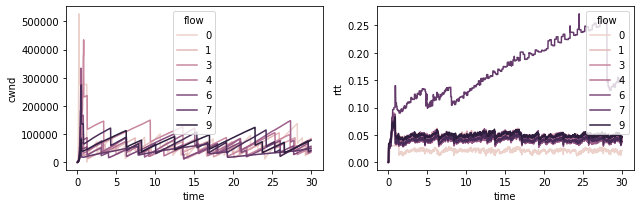

<Figure size 432x288 with 0 Axes>

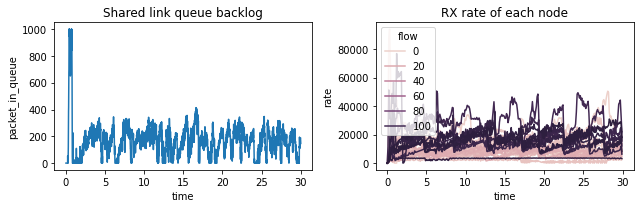

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pipeline
import matplotlib.pyplot as plt

# capitalizing 1st letter of manual params
csvs, qcsv, rcsv = [], [], []
raw_folder = '../BBR_test/ns-3.27/MboxStatistics/'
Run_id = [
    176, 177,   # same, but add reverse cross traffic w/ 30M x 10

    664, 665,   # 10+10, inter 1000p, codel, proc = 10us
    245, 246,   # 10+10, inter 100p, codel, proc = 10us
    253, 255,   # 10+10, inter 100p, red
    254, 256,   # 10+10, inter 1000p, red
    174, 175,   # 10+10, inter 1000p
    563, 564,   # 10+10 case, inter 100p, w/ codel setting fixed
    # old
    612, 613,
    359, 360,
    665, 666,   # 10+10 case, shared 200M, cRate 8M, inter 100p, default 1000p, rx Edge 10
    463, 464
]
N_flows = [10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 4]
for rid, n_flow in zip(Run_id, N_flows):
    csvs.append((f'all-data_{rid}.csv', n_flow))
    qcsv.append(f'queue_{rid}.csv')
    rcsv.append(f'rate_{rid}.csv')

Csv_files = csvs[:2]
Fields = ['cwnd', 'rtt']         # candidates: cwnd, rtt, llr, drop, bytes_in_flight, cstate

for csvs in [qcsv, rcsv]:
    for i, csv in enumerate(csvs):
        if 'tmp' not in csv:
            csvs[i] = raw_folder + csv

Qcsv_file = qcsv[0]
qdf = pd.read_csv(Qcsv_file, index_col=False)


dfs, ppls, qdfs, rdfs = [], [], [], []

# begin plotting
for i, entry in enumerate(Csv_files):
    csv, n = entry[0], entry[1]
    if 'tmp' not in csv:
        csv = raw_folder + csv
    df = pd.read_csv(csv, index_col=False)
    ppl = pipeline.Pipeline(csv, f'ipybn_{i}')
    dfs.append(df)
    ppls.append(ppl)
    print(csv, 'n_flow:', n)
    ppl.plot_flows(show_flow=n, fields=Fields)      # general plot
    
    qdf1 = pd.read_csv(qcsv[i], index_col=False)
    qdfs.append(qdf1)
    rdf1 = pd.read_csv(rcsv[i], index_col=False)
    rdfs.append(rdf1)

    fig, ax = plt.subplots(1, 2, figsize=(9,3))
    sns.lineplot(x='time', y='packet_in_queue', data=qdf1, ax=ax[0])
    ax[0].set_title('Shared link queue backlog')
    sns.lineplot(x='time', y='rate', hue='flow', data=rdf1, ax=ax[1])
    ax[1].set_title('RX rate of each node')
    plt.tight_layout()
    plt.show()

# plt.show()



### Input Series & Visualization
Obtains the non-cobtnk and cobtnk series with given field, and the first 2 flows as the inputs of later correlation

TODO: 
    1. Cubic case?
    2. Different cycles => different delay/ bw?
    3. Different queue size?

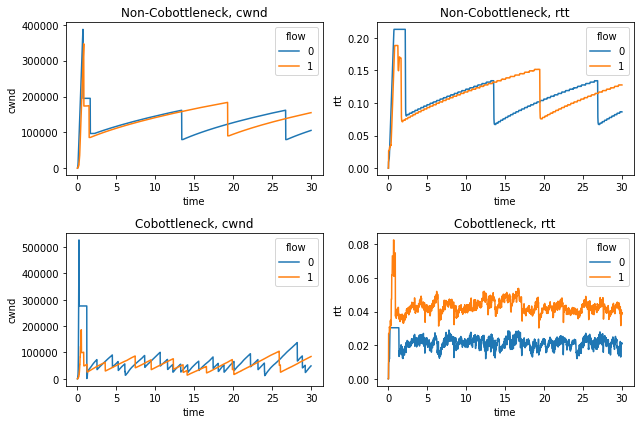

In [2]:
# manually input the run id, flow id, and field
# nonco_df and co_df are what we use exactly as inputs of correlation
# fields = ['cwnd', 'rtt']                  # candidates: cwnd, rtt, llr, drop, bytes_in_flight, cstate
fields = Fields
nonco_df = dfs[0][['time', 'flow'] + fields]
co_df = dfs[1][['time', 'flow'] + fields]
# co_df['queue'] = qdf['packet_in_queue']     # TODO: temp hack
cases = ['Non-Cobottleneck', 'Cobottleneck']

# two flows from Non-Cobtnk case
fig, ax = plt.subplots(len(fields),2, figsize=(9,6))
for i, df in enumerate([nonco_df, co_df]):
    for j, field in enumerate(fields):
        df = df[df.flow < 2]        # only the two normal flows
        sns.lineplot(x='time', y=field, hue='flow', data=df, ax=ax[i, j])
        ax[i, j].set_title(cases[i] + f', {field}')
plt.tight_layout()


##### Discussion 
1. Currently we can only extract the linear information from the RTT, which should only work in clean environment (e.g. low speed network).
2. The correlation or mutual information between time series may not have practical meaning, and we may need to use some other random variables.
3. More theoretical analysis is needed to address the relationship between these signals and queue status.

#### Get Inter-Decrease Time from Sequence

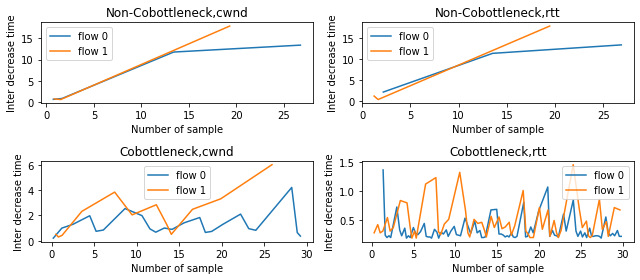

In [3]:
def inter_decrease_time(df, dec=None):
    """Given a time series df, return a list of inter decrease time.
    """
    assert 'time' in df.columns
    field = df.columns[-1]          # assuming the first is 'time'
    res = pd.DataFrame(columns=['time', 'interval'])
    t_last = 0
    t_unit = df.iloc[1]['time'] - df.iloc[0]['time']
    for i in range(len(df)):
        if not i:
            continue
        row = df.iloc[i]
        interval = row['time'] - t_last
        if row[field] < df.iloc[i - 1][field] - dec and interval > 0.2:     # hack to denoise, TODO
            tmp = pd.DataFrame([[row['time'], interval]], columns=res.columns)
            res = res.append(tmp)
            t_last = row['time']
    return res.copy()

fig, ax = plt.subplots(len(fields), 2, figsize=(9,4))
dec = [1000, 0.002]             # TODO: hack for now
for i, df in enumerate([nonco_df, co_df]):
    for j, field in enumerate(fields):
        for flow in [0, 1]:
            data = df[df.flow == flow][['time', field]]
            res = inter_decrease_time(data, dec[j])
            ax[i, j].plot(res.time, res.interval)
        ax[i, j].legend(['flow 0', 'flow 1'])
        ax[i, j].set_ylabel(f'Inter decrease time')
        ax[i, j].set_xlabel(f'Number of sample')
        ax[i, j].set_title(cases[i] + ',' + field)
plt.tight_layout()
plt.show()
    

Comment:
correlation with time series but not the same number of samples?


## Correlation

### Linear Correlation & Mutual Information
TODO: seems the abosolute value of cwnd matters, i.e. co-btnk should have a close cwnd value due to the TCP fairness; this is also neglected by linear correlation

What's the exact meaning and typical usage of these metrics? 

- linear: Linear correlation, cov(X, Y) / std(X) std(Y), [-1, 1].
- rank: Rank correlation, using rank instead of the absolute value, [-1, 1].
- adjusted_mutual_info_score: Mutual info between two clusterings (in nat), i.e. a measure of the similarity between **two labels of the same data (label_true and label_pred)**, adjusted against the fact that MI is larger when the cluster is larger. 
    - Not quite make sense for our signals like cwnd or RTT;
- mutual_info_classif: Estimate mutual information for a **discrete** target variable (in nat), i.e. how dependent y is on X, where X is n_samples x n_features, while y is the target vector.
- mutual_info_regression: Estimate mutual information for a **continuous** target variable (in nat).

#### Calculate the Scores

In [4]:
from collections import OrderedDict
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression


score_func = OrderedDict([
    ('linear', lambda s1, s2: s1.corr(s2)),
    ('rank', lambda s1, s2: s1.corr(s2, method='spearman')),
    ('cluster_minfo', lambda s1, s2: adjusted_mutual_info_score(s1, s2)),
    ('discrete_minfo', lambda s1, s2: mutual_info_classif(s1, s2)),
    ('continuous_minfo', lambda s1, s2: mutual_info_regression(s1, s2))
])

cols = ['case', 'corr', 'score', 'field']
res_df = pd.DataFrame(columns=cols)
for i, df in enumerate([nonco_df, co_df]):
    for tag, func in score_func.items():
        for field in fields:
            s1 = df[df.flow == 0].reset_index(drop=True).copy()[field]
            s2 = df[df.flow == 1].reset_index(drop=True).copy()[field]
            if abs(len(s1) - len(s2)) < 2:
                if len(s1) < len(s2):
                    s2 = s2[:len(s1)]
                else:
                    s1 = s1[:len(s2)]
            try:
                if tag in ['discrete_minfo', 'continuous_minfo']:
                    s1 = s1.to_numpy().reshape(-1, 1)
                    score = func(s1, s2)[0]
                else:
                    score = func(s1, s2)
            except:
                print(f'Invalid data and score: {i}, {tag} w/ {field}')
                score = None
            res_df = res_df.append(pd.DataFrame([[i, tag, score, field]], columns=cols))

print('Score result loaded.')


/home/sapphire/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Invalid data and score: 0, discrete_minfo w/ rtt


/home/sapphire/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Invalid data and score: 1, discrete_minfo w/ rtt
Score result loaded.


#### Plot Scores vs Correlation Approach w/ Case for Fields

,case,corr,score,field
0,0,rank,-0.049574,cwnd
0,0,rank,-0.076784,rtt
0,1,rank,-0.130206,cwnd
0,1,rank,0.463647,rtt


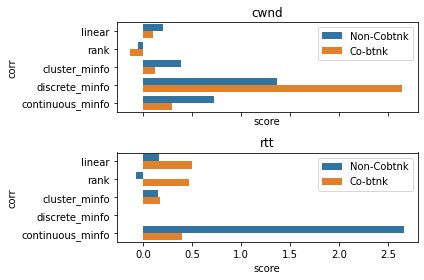

In [5]:
# plot them
fig, ax = plt.subplots(len(fields), 1, sharex=True)
for i, field in enumerate(fields):
    sns.barplot(y='corr', x='score', hue='case', ax=ax[i],
        data=res_df[res_df.field == field])
    ax[i].set_title(field)
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, ['Non-Cobtnk', 'Co-btnk'])
plt.tight_layout()

res_df.query('corr == "rank"')

### Queue Backlog Study

#### Compare Queue Back log with Sum RX Rate and Sum of cwnd

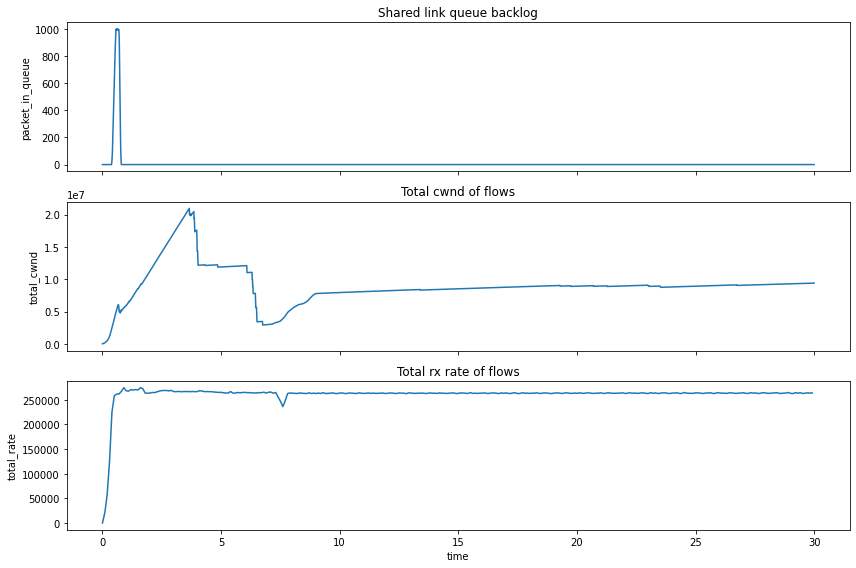

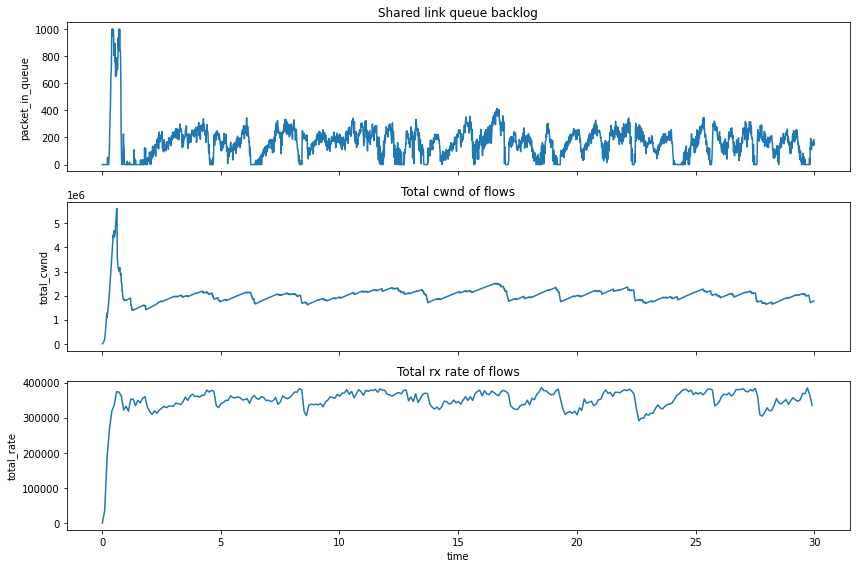

In [6]:
for i in range(2):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
    sns.lineplot(x='time', y='packet_in_queue', data=qdfs[i], ax=ax[0])
    ax[0].set_title('Shared link queue backlog')

    # plot the sum of cwnd for tx
    ddf = dfs[i].copy()
    ddf['total_cwnd'] = ddf.groupby('time')['cwnd'].transform(sum)
    ddf = ddf.drop_duplicates(subset=['time'])
    sns.lineplot(x='time', y='total_cwnd', data=ddf, ax=ax[1])
    ax[1].set_title('Total cwnd of flows')

    # plot the sum of rx rate
    rdf = rdfs[i].copy()
    rdf['total_rate'] = rdf.groupby('time')['rate'].transform(sum)
    rdf = rdf.drop_duplicates(subset=['time'])
    sns.lineplot(x='time', y='total_rate', data=rdf, ax=ax[2])
    ax[2].set_title('Total rx rate of flows')

    plt.tight_layout()

#### Correlation w/ Queue Backlog
Clear the initial outlier due to no initialization in ns-3.

Issues: correlation between cwnd and queue backlog has no meaning, maybe we should use inter-loss time as the random variable. 

/home/sapphire/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Correlation between the queue occupancy and fields')

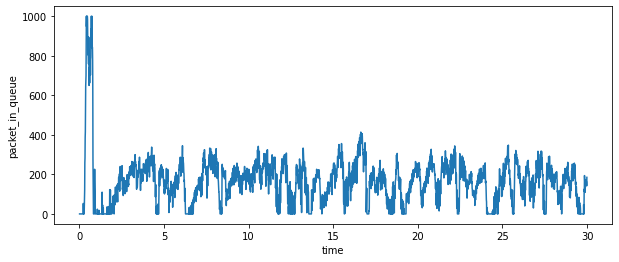

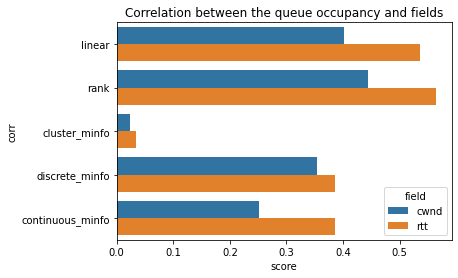

In [7]:
# plot the queue backlog
plt.figure(figsize=(10,4))
# qdf = qdf[qdf.packet_in_queue < 1e6]
sns.lineplot(x='time', y='packet_in_queue', data=qdfs[1])

# correlation between queue backlog and flow 0 signals in cobtnk case
qcols = ['corr', 'score', 'field']
qres_df = pd.DataFrame(columns=qcols)
for tag, func in score_func.items():
    for field in fields:
        s1 = co_df[co_df.flow == 0].reset_index(drop=True).copy()[field]
        # s2 = df[df.flow == 1].reset_index(drop=True).copy()[field]
        s2 = qdfs[1]['packet_in_queue']
        if abs(len(s1) - len(s2)) < 2:
            if len(s1) < len(s2):
                s2 = s2[:len(s1)]
            else:
                s1 = s1[:len(s2)]
        try:
            if tag in ['discrete_minfo', 'continuous_minfo']:
                s1 = s1.to_numpy().reshape(-1, 1)
                score = func(s1, s2)[0]
            else:
                score = func(s1, s2)
        except:
            print(f'Invalid data and score: {i}, {tag} w/ {field}')
            score = None
        qres_df = qres_df.append(pd.DataFrame([[tag, score, field]], columns=qcols))

# plot the correlation
plt.figure()
ax = sns.barplot(y='corr', x='score', hue='field', data=qres_df)
ax.set_title('Correlation between the queue occupancy and fields')


#### Plot Scores vs Intervals w Field/Signal
Hypothesis: the mutual info might be sensitive to the time
    - Actually the random process of cwnd and rtt may not be a pure random variable

In [8]:
a = [0,1]
df.query(f'flow in {a} and cwnd == b')

UndefinedVariableError: name 'b' is not defined

In [ ]:
fig, ax = plt.subplots(len(score_func), 2)
for j, corr in enumerate(score_func.keys()):
    for i in [0, 1]:
        # ppls[i].plot_score_vs_intervals_w_signal(0, 1, [0.01, 0.05, 0.1], corr)

        res = ppls[i].calculate_scores(0, 1, intervals=[0.01, 0.05, 0.1])
        # res = res.loc[(res['corr'] == corr) & (res['signal'] in fields)]
        res = res.query(f"corr == '{corr}' and signal in {fields}")
        
        sns.barplot(y='interval', x='score', hue='signal', data=res, ax=ax[j, i])
        ax[j, i].set_title(f'{corr}, cobtnk: {i}')

# TODO: DOESN'T WORK, the code above is too hard to debug, and coupling data and visual
#       NEED MANUAL CODING!




### Traditional: RTT Processing from TCP Congestion Signature
TODO